In [5]:
import os 
import numpy as np
import random
import math
import json
from functools import partial
import urllib.request
from typing import List, Optional, Tuple
from urllib.error import HTTPError

## Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgb
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.nn.functional import softmax
import torch.optim as optim
import torchvision
from torch import Tensor
from torchvision.datasets import CIFAR100
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from IPython.core.interactiveshell import InteractiveShell

from model import PositionalEncoding

In [6]:
DATASET_PATH = "data"  # path to datasets (e.g. CIFAR10)
CHECKPOINT_PATH = "saved_models/tutorial6"  # path to pretrained models

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [7]:
# set seed
seed_number = 0
torch.manual_seed(seed_number)

# set device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda:0


## Miscellaneous & Tests

#### Visualization of positional encoding:

torch.Size([48, 96])


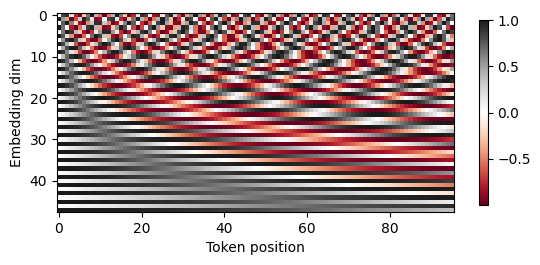

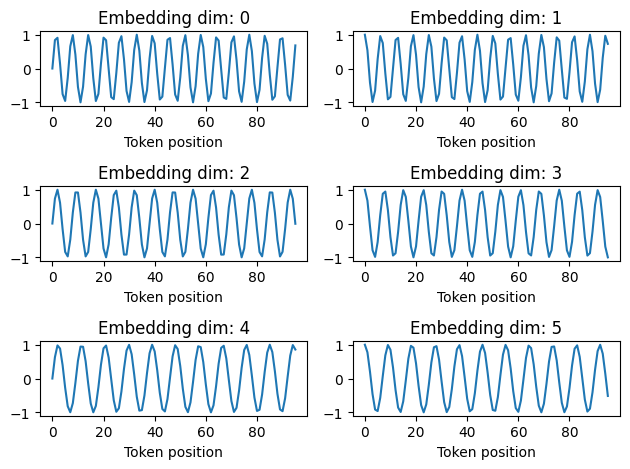

In [8]:
encoder_class = PositionalEncoding(max__seq_length=96, embed_dim=48)
pos_encod = encoder_class.pos_encod.squeeze().T  # transpose because of `.imshow`
print(f"{pos_encod.shape}")

plt.imshow(pos_encod, cmap="RdGy")
plt.xlabel("Token position")
plt.ylabel("Embedding dim")
plt.colorbar(shrink=0.5)
plt.show()
plt.close()

fig, axs = plt.subplots(nrows=3, ncols=2,)
for (idx, ax) in enumerate(axs.flat):
    ax.plot(pos_encod[idx])
    ax.set_title(f"Embedding dim: {idx}")
    ax.set_xlabel("Token position")
plt.tight_layout()
plt.show()
plt.close()

In [30]:
max__seq_length = int(1e4)
torch.sin(
    torch.arange(0, max__seq_length, 1)
)

tensor([0.0000, 0.8415, 0.9093,  ..., 0.4369, 0.9930, 0.6361])

In [32]:
max__seq_length = int(1e4)
torch.sin(
    torch.arange(0, max__seq_length, 1, dtype=torch.float32)
)

tensor([0.0000, 0.8415, 0.9093,  ..., 0.4369, 0.9930, 0.6361])

In [17]:
embed_dim = 512
embed_idx = torch.arange(
    start=0,
    end=embed_dim // 2,
    step=1,
)
int(1e4)**(2 * embed_idx / embed_dim)

tensor([1.0000e+00, 1.0366e+00, 1.0746e+00, 1.1140e+00, 1.1548e+00, 1.1971e+00,
        1.2409e+00, 1.2864e+00, 1.3335e+00, 1.3824e+00, 1.4330e+00, 1.4855e+00,
        1.5399e+00, 1.5963e+00, 1.6548e+00, 1.7154e+00, 1.7783e+00, 1.8434e+00,
        1.9110e+00, 1.9810e+00, 2.0535e+00, 2.1288e+00, 2.2067e+00, 2.2876e+00,
        2.3714e+00, 2.4582e+00, 2.5483e+00, 2.6416e+00, 2.7384e+00, 2.8387e+00,
        2.9427e+00, 3.0505e+00, 3.1623e+00, 3.2781e+00, 3.3982e+00, 3.5227e+00,
        3.6517e+00, 3.7855e+00, 3.9242e+00, 4.0679e+00, 4.2170e+00, 4.3714e+00,
        4.5316e+00, 4.6976e+00, 4.8697e+00, 5.0481e+00, 5.2330e+00, 5.4247e+00,
        5.6234e+00, 5.8294e+00, 6.0430e+00, 6.2643e+00, 6.4938e+00, 6.7317e+00,
        6.9783e+00, 7.2339e+00, 7.4989e+00, 7.7737e+00, 8.0584e+00, 8.3536e+00,
        8.6596e+00, 8.9769e+00, 9.3057e+00, 9.6466e+00, 1.0000e+01, 1.0366e+01,
        1.0746e+01, 1.1140e+01, 1.1548e+01, 1.1971e+01, 1.2409e+01, 1.2864e+01,
        1.3335e+01, 1.3824e+01, 1.4330e+

In [19]:
x = torch.rand(5, 4, 3, 2)
print(f"Tensor x:\n\n{x}\n\n{x.mT}, {x.mT.shape}")

Tensor x:

tensor([[[[0.8466, 0.1409],
          [0.3803, 0.7302],
          [0.8895, 0.1502]],

         [[0.2315, 0.7380],
          [0.9683, 0.9482],
          [0.3074, 0.4757]],

         [[0.1297, 0.9382],
          [0.0478, 0.1242],
          [0.7228, 0.5741]],

         [[0.5719, 0.7463],
          [0.6430, 0.6280],
          [0.8611, 0.0332]]],


        [[[0.9759, 0.0871],
          [0.6696, 0.3150],
          [0.9690, 0.0514]],

         [[0.3370, 0.8649],
          [0.1231, 0.5531],
          [0.1881, 0.8799]],

         [[0.3372, 0.1790],
          [0.6763, 0.4948],
          [0.5172, 0.8204]],

         [[0.6135, 0.1035],
          [0.2792, 0.9711],
          [0.8834, 0.8678]]],


        [[[0.1237, 0.6181],
          [0.8063, 0.8307],
          [0.4757, 0.7232]],

         [[0.0771, 0.2667],
          [0.3264, 0.5196],
          [0.3408, 0.8035]],

         [[0.7160, 0.1288],
          [0.0985, 0.9340],
          [0.8809, 0.3559]],

         [[0.7541, 0.2961],
          [

In [17]:
batch_size = 256
num_heads = 8
seq_length = 256
head_dim = 64

qkv = torch.rand(
    batch_size,
    num_heads,
    seq_length,
    3 * head_dim,
)
    
q = qkv[:, :, :, :head_dim]

k = qkv[:, :, :, head_dim : 2 * head_dim]

v = qkv[:, :, :, 2 * head_dim : 3 * head_dim]

In [18]:
q_new, k_new, v_new = qkv.chunk(3, dim=-1)

assert torch.allclose(q, q_new)
assert torch.allclose(k, k_new)
assert torch.allclose(v, v_new)

In [8]:
import cpuinfo

# Getting detailed CPU information
info = cpuinfo.get_cpu_info()

# Print the entire information dictionary
# print(info)

# If you want to print specific details like the brand, you can do so as follows:
print("CPU Brand:", info['brand_raw'])


CPU Brand: Intel(R) Core(TM) i9-10920X CPU @ 3.50GHz


In [11]:
k = torch.rand(3, 2)
print(f"Random tensor:\n\n{k}\n\n{k.mT}, {k.mT.shape}")

Random tensor:

tensor([[0.4901, 0.8964],
        [0.4556, 0.6323],
        [0.3489, 0.4017]])

tensor([[0.4901, 0.4556, 0.3489],
        [0.8964, 0.6323, 0.4017]]), torch.Size([2, 3])


In [10]:
mask = torch.tensor([[0, 2, 3, 4], [0, 1, 2, -3]], dtype=torch.bool)
attn_logits = torch.rand(*mask.shape)
print(f"Mask:\n{mask}\n\nAttention logits:\n{attn_logits}")

Mask:
tensor([[False,  True,  True,  True],
        [False,  True,  True,  True]])

Attention logits:
tensor([[0.4901, 0.8964, 0.4556, 0.6323],
        [0.3489, 0.4017, 0.0223, 0.1689]])


In [11]:
attn_logits.masked_fill_(
    mask==0,
    value=-10
)

tensor([[-10.0000,   0.8964,   0.4556,   0.6323],
        [-10.0000,   0.4017,   0.0223,   0.1689]])

In [12]:
seq_length = 4
d_k = 2
d_v = 3

q = torch.randn(seq_length, d_k)
k = torch.randn(seq_length, d_k)
v = torch.randn(seq_length, d_v)

attention, values = scaled_dot_product_attn(
    q=q,
    k=k,
    v=v,
)
print(f"Attention weights:\n\n{attention}\n\nValues:\n\n{values}")

Attention weights:

tensor([[-0.4961, -0.0490, -0.9716],
        [-0.4659, -0.0843, -0.9952],
        [-0.4182, -0.0311, -0.9517],
        [-0.3358,  0.6520, -0.3380]])

Values:

tensor([[0.3778, 0.3911, 0.0938, 0.1373],
        [0.2806, 0.4816, 0.1043, 0.1335],
        [0.1887, 0.5252, 0.1405, 0.1455],
        [0.3111, 0.0778, 0.2936, 0.3175]])


In [13]:
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
print(f"Q\n\n{q}\n")
print(f"K\n\n{k}\n")
print(f"V\n\n{v}\n")

Q

tensor([[ 1.1317, -0.6455],
        [-1.7703,  0.2143],
        [-0.5382,  0.5880]])

K

tensor([[ 1.6059,  0.4279],
        [-0.6776,  1.0422],
        [-1.9513,  0.4186]])

V

tensor([[ 3.3214,  0.8764],
        [ 1.2345, -1.1642],
        [-0.0240,  0.6480]])



In [14]:
attention, values = scaled_dot_product_attn(q, k, v)
print(f"Values\n\n{values}\n")
print(f"Attention\n\n{attention}\n")

Values

tensor([[0.8476, 0.1030, 0.0494],
        [0.0094, 0.1807, 0.8098],
        [0.1260, 0.3879, 0.4860]])

Attention

tensor([[ 2.9412,  0.6550],
        [ 0.2350,  0.3226],
        [ 0.8858, -0.0263]])



In [15]:
softmax(torch.tensor([0.1037, -0.1441, -0.1073]))

/tmp/ipykernel_177/739439436.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.tensor([0.1037, -0.1441, -0.1073]))


tensor([0.3861, 0.3013, 0.3126])

In [16]:
seq_len, d_k = 3, 2
q = torch.tensor([[[-0.1335, 0.3415], [-0.0716, -0.0909], [-1.3297, -0.5426]]])
k = torch.tensor([[[0.5471, 0.6431], [-0.7905, -0.9058], [-0.2607, -0.5465]]])
v = torch.tensor([[[2.1174, -1.7118], [0.1651, 1.5819], [0.4485, 0.0330]]])
values, attention = scaled_dot_product_attn(q, k, v)
print(f"Q\n\n{q}\n")
print(f"K\n\n{k}\n")
print(f"V\n\n{v}\n")
print(f"Values\n\n{values}\n")
print(f"Attention\n\n{attention}\n")

Q

tensor([[[-0.1335,  0.3415],
         [-0.0716, -0.0909],
         [-1.3297, -0.5426]]])

K

tensor([[[ 0.5471,  0.6431],
         [-0.7905, -0.9058],
         [-0.2607, -0.5465]]])

V

tensor([[[ 2.1174, -1.7118],
         [ 0.1651,  1.5819],
         [ 0.4485,  0.0330]]])

Values

tensor([[[ 1.0074, -0.1738],
         [ 0.8519,  0.0590],
         [ 0.4358,  0.7891]]])

Attention

tensor([[[0.3861, 0.3013, 0.3126],
         [0.3024, 0.3575, 0.3401],
         [0.0931, 0.5930, 0.3139]]])



In [17]:
out = q @ k.mT / math.sqrt(d_k)
softmax(out, dim=-1)

tensor([[[0.3861, 0.3013, 0.3126],
         [0.3024, 0.3575, 0.3401],
         [0.0931, 0.5930, 0.3139]]])

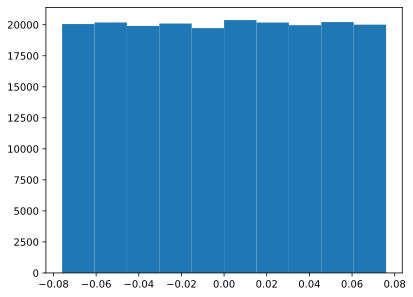

In [8]:
model = nn.Linear(
    in_features=256,
    out_features=784,
)
torch.nn.init.xavier_uniform_(model.weight, gain=1.0)
plt.hist(
    model.weight.flatten().detach().numpy()
)
plt.show()
plt.close()

In [24]:
model.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [17]:
model.bias.shape, model.bias.dtype

(torch.Size([784]), torch.float32)

In [9]:
torch.max(
    torch.abs(
        model.weight
    )
)

tensor(0.0760, grad_fn=<MaxBackward1>)